In [1]:
# import the libraries as shown below
import keras
from keras import optimizers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

In [2]:
# Import the Vgg 19 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

image_size=[224,224]
vgg = VGG19(input_shape=image_size + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [3]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [4]:
# useful for getting number of output classes
folders = glob('../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/*')

In [5]:
#folders

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
layer = Dense(128, activation="relu", kernel_initializer="he_uniform")(x)
layer = Dense(64, activation="relu", kernel_initializer="he_uniform")(layer)
layer = Dense(32, activation="relu", kernel_initializer="he_uniform")(layer)
layer = Dense(16, activation="relu", kernel_initializer="he_uniform")(layer)

In [7]:
prediction = Dense(len(folders), activation='softmax')(layer)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [8]:

# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
# tell the model what cost and optimization method to use
model.compile(
 loss='binary_crossentropy',
 optimizer=keras.optimizers.Adam(lr=3e-4),
  metrics=['accuracy']
)

In [10]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 100,
                                                 class_mode = 'binary')

Found 6633 images belonging to 2 classes.


In [12]:
print(training_set.class_indices)

{'def_front': 0, 'ok_front': 1}


In [13]:
test_set = test_datagen.flow_from_directory('../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test',
                                            target_size = (224, 224),
                                            batch_size = 100,
                                            class_mode = 'binary')

Found 715 images belonging to 2 classes.


In [14]:
# fit the model
# Run the cell. It will take some time to execute
fit = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
67/67 [==============================] - 130s 2s/step - loss: 0.6977 - accuracy: 0.5206 - val_loss: 0.6932 - val_accuracy: 0.4923
Epoch 2/10
67/67 [==============================] - 102s 2s/step - loss: 0.6932 - accuracy: 0.5082 - val_loss: 0.6932 - val_accuracy: 0.4783
Epoch 3/10
67/67 [==============================] - 108s 2s/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4741
Epoch 4/10
67/67 [==============================] - 102s 2s/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 5/10
67/67 [==============================] - 100s 1s/step - loss: 0.6932 - accuracy: 0.5082 - val_loss: 0.6932 - val_accuracy: 0.4699
Epoch 6/10
67/67 [==============================] - 99s 1s/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.4937
Epoch 7/10
67/67 [==============================] - 98s 1s/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5021
Epoch 8/10
67/6

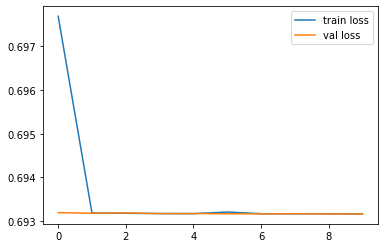

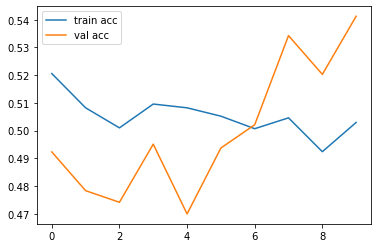

<Figure size 432x288 with 0 Axes>

In [15]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(fit.history['loss'], label='train loss')
plt.plot(fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(fit.history['accuracy'], label='train acc')
plt.plot(fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

In [17]:
y_pred = model.predict(test_set)

In [18]:
y_pred

array([[0.50126415, 0.49873585],
       [0.49973673, 0.5002633 ],
       [0.50076926, 0.49923074],
       ...,
       [0.5010009 , 0.49899912],
       [0.49632335, 0.50367665],
       [0.50317997, 0.49682   ]], dtype=float32)

In [19]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [20]:
y_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [22]:
model=load_model('model_vgg19.h5')

In [23]:
#PREDICTING OK CASTING PRODUCT

img=image.load_img('../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/ok_front/cast_ok_0_1140.jpeg',target_size=(224,224))

In [24]:
x=image.img_to_array(img)
x

array([[[183., 183., 183.],
        [183., 183., 183.],
        [183., 183., 183.],
        ...,
        [166., 166., 166.],
        [166., 166., 166.],
        [167., 167., 167.]],

       [[183., 183., 183.],
        [183., 183., 183.],
        [183., 183., 183.],
        ...,
        [167., 167., 167.],
        [167., 167., 167.],
        [167., 167., 167.]],

       [[183., 183., 183.],
        [183., 183., 183.],
        [183., 183., 183.],
        ...,
        [166., 166., 166.],
        [166., 166., 166.],
        [164., 164., 164.]],

       ...,

       [[163., 163., 163.],
        [163., 163., 163.],
        [163., 163., 163.],
        ...,
        [141., 141., 141.],
        [141., 141., 141.],
        [141., 141., 141.]],

       [[163., 163., 163.],
        [163., 163., 163.],
        [163., 163., 163.],
        ...,
        [141., 141., 141.],
        [141., 141., 141.],
        [141., 141., 141.]],

       [[163., 163., 163.],
        [163., 163., 163.],
        [163., 1

In [25]:
x.shape

(224, 224, 3)

In [26]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [27]:
model.predict(img_data)

array([[0.2724045, 0.7275955]], dtype=float32)

In [28]:
a=np.argmax(model.predict(img_data), axis=1)

OK casting product


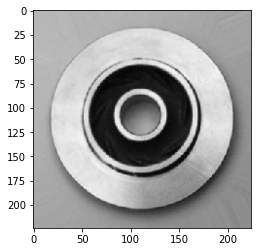

In [29]:
if(a==1):
    print("OK casting product")
    plt.imshow(img)
else:
    print("Defective casting product")
    plt.imshow(img)

In [30]:
#y_true and y_pred
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_set:
  i += 1
  y = np.argmax(model.predict(data), axis=1)
  y_true = np.append(y_true, labels)
  y_pred = np.append(y_pred, y)
  
  if i == test_set.samples // 100 + 1:
    break

In [31]:
from sklearn.metrics import confusion_matrix,accuracy_score
metrics=confusion_matrix(y_true,y_pred)
print(metrics)

[[318 135]
 [193  69]]


In [32]:
accuracy=accuracy_score(y_true,y_pred)
print(accuracy)

0.5412587412587413
